In [19]:
!pip install pandas matplotlib sklearn fbprophet plotly requests

In [20]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression, TheilSenRegressor, HuberRegressor, RANSACRegressor, RidgeCV
import numpy as np
import requests

In [23]:
DATA_URL = ('https://covid.ourworldindata.org/data/owid-covid-data.csv')
r = requests.get(DATA_URL)  
with open('../data/owid-covid-data.csv', 'wb') as f:
    f.write(r.content)


#### Filtro nos dados para retornar apenas os dados consolidados mundiais e soma para conferir com o worldometer

In [24]:
df = pd.read_csv('../data/owid-covid-data.csv')
df = df[df['location'] == 'World'].copy()
df['new_cases'].sum()

40856197.0

#### Selecionar as colunas desejaveis e agrupar por data

In [4]:
df = df[['date', 'total_cases']]
df = df.groupby(['date']).sum()
df.reset_index(drop=False, inplace=True)

#### Cria uma nova coluna com o indice dos dias começando de 1

In [5]:
df['day'] = range(1, len(df) + 1)

#### Ajusta o shape do objeto

In [6]:
X = df['day'].to_numpy().reshape(-1, 1)
y = df['total_cases'].astype(int).to_numpy().reshape(-1, 1)

#### Visualizando os dados

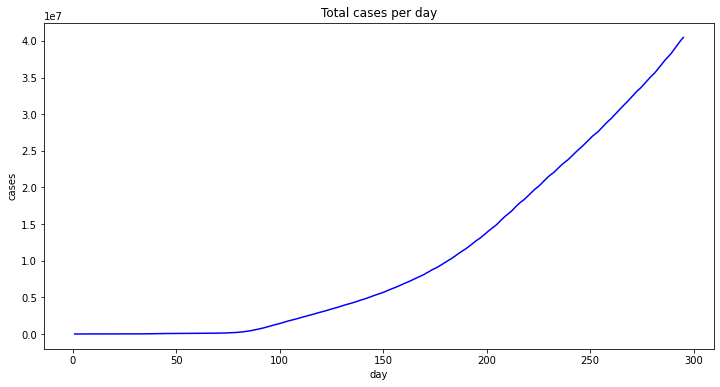

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(X.reshape(-1) , y.reshape(-1),'b')
plt.xlabel('day')
plt.ylabel('cases')
plt.title('Total cases per day')
plt.show()

## Teste1 -  Regressão linear

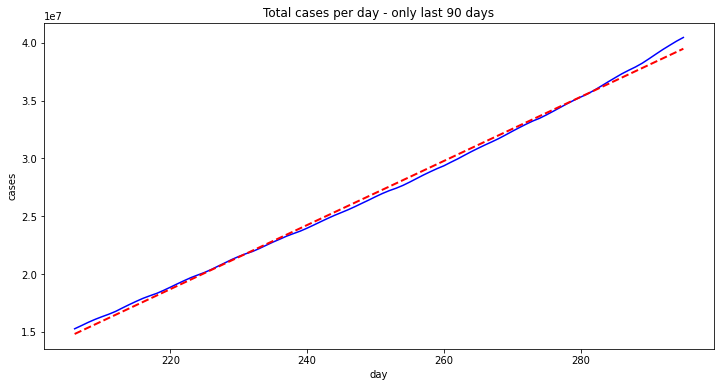

In [8]:
from sklearn import linear_model
lm = linear_model.LinearRegression()
model = lm.fit(X[-90:], y[-90:].reshape(-1))
y_predict = model.predict(X[-90:]).astype('int')

# plot
plt.figure(figsize=(12, 6))
plt.plot(X[-90:].reshape(-1) , y[-90:].reshape(-1),'b')
plt.plot(X[-90:], y_predict, color='red', linestyle='--',
                 linewidth=2)

plt.xlabel('day')
plt.ylabel('cases')
plt.title('Total cases per day - only last 90 days')
plt.show()

In [9]:
yesterday = X.reshape(-1)[-1]
tomorrow = yesterday + 2
predict = lm.predict([[tomorrow]]).astype('int')
percent = 1 - predict / y.reshape(-1)[-1]
print("Previsão amanhã: {:.2%}".format(percent[0]))

Previsão amanhã: 1.04%


A regressão linear funciona muito bem desde que não utilize toda a massa de dados, por exemplo se usar todo o conjunto o slope fica muito fora gerando um desvio muito grande, exemplo abaixo:

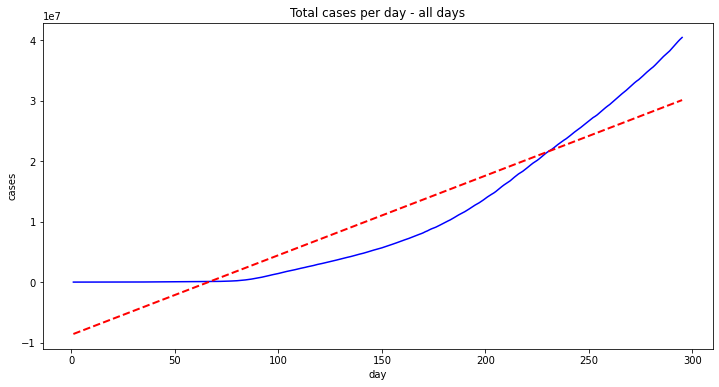

In [10]:
model = lm.fit(X, y.reshape(-1))
y_predict = model.predict(X).astype('int')

# plot
plt.figure(figsize=(12, 6))
plt.plot(X.reshape(-1) , y.reshape(-1),'b')
plt.plot(X, y_predict, color='red', linestyle='--',
                 linewidth=2)

plt.xlabel('day')
plt.ylabel('cases')
plt.title('Total cases per day - all days')
plt.show()

In [11]:
yesterday = X.reshape(-1)[-1]
tomorrow = yesterday + 2
predict = lm.predict([[tomorrow]]).astype('int')
percent = 1 - predict / y.reshape(-1)[-1]
print("Previsão amanhã : {:.2%}".format(percent[0]))

Previsão amanhã : 24.94%


## Teste 2 - Time Series

Realizando um teste com o prophet do facebook

In [12]:
new_df = df[['date', 'total_cases']].copy()
new_df.rename(columns={'date':'ds', 'total_cases':'y'}, inplace=True)
new_df.head()
from fbprophet import Prophet
m = Prophet(yearly_seasonality=True, daily_seasonality=True)
m.fit(new_df)

Dados futuros

In [13]:
future = m.make_future_dataframe(periods=30)
future.tail()

,ds
320,2020-11-15
321,2020-11-16
322,2020-11-17
323,2020-11-18
324,2020-11-19


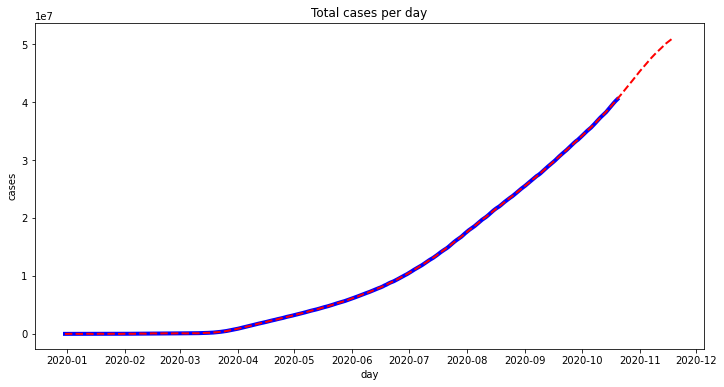

In [14]:
forecast = m.predict(future)
plt.figure(figsize=(12, 6))
plt.plot(new_df['ds'].astype('datetime64[ns]').to_numpy().reshape(-1) , new_df['y'].to_numpy().reshape(-1),'b', linewidth=4)
plt.plot(forecast['ds'].to_numpy().reshape(-1), forecast['yhat'].astype(int).to_numpy().reshape(-1), color='red', linestyle='--',
                 linewidth=2)

plt.xlabel('day')
plt.ylabel('cases')
plt.title('Total cases per day')
plt.show()

A margem de erro é minima, porém nesse caso para garantir vou usar uma massa de teste ...

In [15]:
size_of_test = int(len(new_df) * 0.2)
train = new_df.head(len(df)-30)
test = new_df.tail(30)
len(train), len(test), len(new_df)

(265, 30, 295)

In [16]:
m = Prophet(yearly_seasonality=True, daily_seasonality=True)
m.fit(train)

In [17]:
future = m.make_future_dataframe(periods=30)
future.tail()

,ds
290,2020-10-16
291,2020-10-17
292,2020-10-18
293,2020-10-19
294,2020-10-20


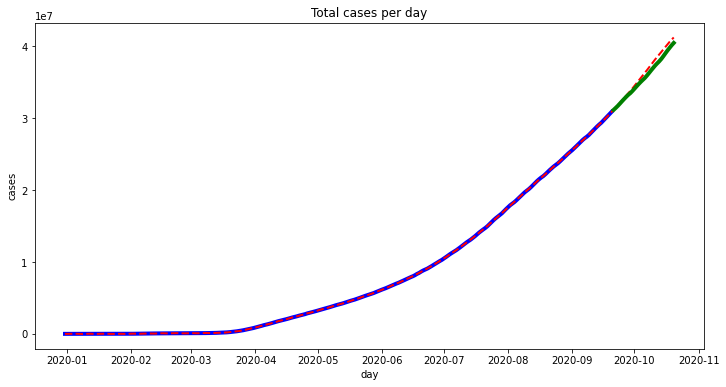

In [18]:
forecast = m.predict(future)
plt.figure(figsize=(12, 6))
plt.plot(train['ds'].astype('datetime64[ns]').to_numpy().reshape(-1) , train['y'].to_numpy().reshape(-1),'b', linewidth=4)
plt.plot(forecast['ds'].to_numpy().reshape(-1), forecast['yhat'].astype(int).to_numpy().reshape(-1), color='red', linestyle='--',
                 linewidth=2)
plt.plot(test['ds'].astype('datetime64[ns]').to_numpy().reshape(-1) , test['y'].to_numpy().reshape(-1),'b', linewidth=4, color='green')

plt.xlabel('day')
plt.ylabel('cases')
plt.title('Total cases per day')
plt.show()